In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", reshape=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
learning_rate = 0.001
training_iters =  300
batch_size = 64
display_step = 100

In [5]:
# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.8 # Dropout, probability to keep units

In [11]:
import os
session = tf.Session()
saver = tf.train.Saver()
save_dir = 'checkpoint'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'best_validation')
init = tf.global_variables_initializer()
session.run(init)

try:
    print("trying to restore last checkpoint")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

trying to restore last checkpoint
Failed to restore checkpoint. Initializing variables instead.


In [7]:
a = tf.placeholder(tf.float32, (100,28,28,1))
x_image = tf.reshape(a,[-1,28,28,1])
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)
keep_prob = tf.placeholder(tf.float32)
session.run(tf.global_variables_initializer())


## init alexnet

In [77]:
def conv2d(name, l_input, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(l_input, w, strides=[1, 1, 1, 1], 
                                                  padding='SAME'),b), name=name)

def max_pool(name, l_input, k):
    return tf.nn.max_pool(l_input, ksize=[1, k, k, 1], strides=[1, k, k, 1], 
                          padding='SAME', name=name)

def norm(name, l_input, lsize=4):
    return tf.nn.lrn(l_input, lsize, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name=name)

def alex_net_original(_X, _weights, _biases, _dropout):
    # Reshape input picture
   # _X = tf.reshape(_X, shape=[-1, 28, 28, 1]) ## we are doing this already, let us try sending 'a' placeholder as an input

    # Convolution Layer
    conv1 = conv2d('conv1', _X, _weights['wc1'], _biases['bc1'])
    # Max Pooling (down-sampling)
    pool1 = max_pool('pool1', conv1, k=2)
    # Apply Normalization
    norm1 = norm('norm1', pool1, lsize=4)
    # Apply Dropout
    norm1 = tf.nn.dropout(norm1, _dropout)

    # Convolution Layer
    conv2 = conv2d('conv2', norm1, _weights['wc2'], _biases['bc2'])
    # Max Pooling (down-sampling)
    pool2 = max_pool('pool2', conv2, k=2)
    # Apply Normalization
    norm2 = norm('norm2', pool2, lsize=4)
    # Apply Dropout
    norm2 = tf.nn.dropout(norm2, _dropout)

    # Convolution Layer
    conv3 = conv2d('conv3', norm2, _weights['wc3'], _biases['bc3'])
    # Max Pooling (down-sampling)
    pool3 = max_pool('pool3', conv3, k=2)
    # Apply Normalization
    norm3 = norm('norm3', pool3, lsize=4)
    # Apply Dropout
    norm3 = tf.nn.dropout(norm3, _dropout)

    # Fully connected layer
    # Reshape conv3 output to fit dense layer input
    dense1 = tf.reshape(norm3, [-1, _weights['wd1'].get_shape().as_list()[0]]) ## this is a fully connected layer
    # Relu activation
    dense1 = tf.nn.relu(tf.matmul(dense1, _weights['wd1']) + _biases['bd1'], name='fc1')
    
    # Relu activation
    dense2 = tf.nn.relu(tf.matmul(dense1, _weights['wd2']) + _biases['bd2'], name='fc2') 

    # Output, class prediction
    out = tf.matmul(dense2, _weights['out']) + _biases['out']
    return out, conv1, conv2, conv3, dense1, dense2, norm1, norm2, norm3

In [78]:
weights = {
    'wc1': tf.Variable(tf.random_normal([3, 3, 1, 64])),
    'wc2': tf.Variable(tf.random_normal([3, 3, 64, 128])),
    'wc3': tf.Variable(tf.random_normal([3, 3, 128, 256])),
    'wd1': tf.Variable(tf.random_normal([4*4*256, 1024])),
    'wd2': tf.Variable(tf.random_normal([1024, 1024])),
    'out': tf.Variable(tf.random_normal([1024, 10]))
}
biases = {
    'bc1': tf.Variable(tf.random_normal([64])),
    'bc2': tf.Variable(tf.random_normal([128])),
    'bc3': tf.Variable(tf.random_normal([256])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
session.run(tf.global_variables_initializer())

In [79]:
pred, conv1, conv2, conv3, dense1, dense2, norm1, norm2, norm3 = alex_net_original(x_image, weights, biases, keep_prob)

In [80]:
def alex_net(_X, _weights, _biases, _dropout):

    # Reshape input picture
   # _X = tf.reshape(_X, shape=[-1, 28, 28, 1]) ## we are doing this already, let us try sending 'a' placeholder as an input

    # Convolution Layer
    conv1 = conv2d('conv1', _X, _weights['wc1'], _biases['bc1'])
    # Max Pooling (down-sampling)
    #pool1 = max_pool('pool1', conv1, k=2)
    # Apply Normalization
    #norm1 = norm('norm1', pool1, lsize=4)
    # Apply Dropout
    #norm1 = tf.nn.dropout(norm1, _dropout)

    # Convolution Layer
    conv2 = conv2d('conv2', norm1, _weights['wc2'], _biases['bc2'])
    # Max Pooling (down-sampling)
    #pool2 = max_pool('pool2', conv2, k=2)
    # Apply Normalization
    #norm2 = norm('norm2', pool2, lsize=4)
    # Apply Dropout
    #norm2 = tf.nn.dropout(norm2, _dropout)

    # Convolution Layer
    conv3 = conv2d('conv3', norm2, _weights['wc3'], _biases['bc3'])
    # Max Pooling (down-sampling)
    #pool3 = max_pool('pool3', conv3, k=2)
    # Apply Normalization
    #norm3 = norm('norm3', pool3, lsize=4)
    # Apply Dropout
    #norm3 = tf.nn.dropout(norm3, _dropout)

    # Fully connected layer
    # Reshape conv3 output to fit dense layer input
    #dense1 = tf.reshape(norm3, [-1, _weights['wd1'].get_shape().as_list()[0]]) ## this is a fully connected layer
    # Relu activation
    #dense1 = tf.nn.relu(tf.matmul(dense1, _weights['wd1']) + _biases['bd1'], name='fc1')
    
    # Relu activation
    #dense2 = tf.nn.relu(tf.matmul(dense1, _weights['wd2']) + _biases['bd2'], name='fc2') 

    # Output, class prediction
    out = tf.matmul(dense2, _weights['out']) + _biases['out']
    return out, conv1, conv2, conv3, dense1, dense2

In [13]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(pred, one_hot_y)

print(cross_entropy)
loss_operation = tf.reduce_mean(cross_entropy)
#print(loss_operation)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)


Tensor("Reshape_4:0", shape=(100,), dtype=float32)


In [81]:
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


In [15]:
EPOCHS = 1
BATCH_SIZE = 100

## train the model

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(mnist.train.images)
    
    print("Training...")
   # print()
    for i in range(EPOCHS):
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = mnist.train.images[offset:end], mnist.train.labels[offset:end]
            sess.run(training_operation, feed_dict={a: batch_x, y: batch_y, keep_prob:dropout})
            
        #validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        #print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...
EPOCH 1 ...

Model saved


## restore weights

In [16]:
def restoreWeights():
    for wIdx in range(0, len(weightsConvMat)):
        assign_op = weightsConvMat[wIdx].assign(wOrigConv[wIdx])
        session.run(assign_op)
    
    for wIdx in range(0, len(weightsDenseMat)):
        assign_op = weightsDenseMat[wIdx].assign(wOrigDense[wIdx])
        session.run(assign_op)

In [261]:
restoreWeights()

## store original weights

In [262]:
w1 = weights["wc1"]
w2 = weights["wc2"]
w3 = weights["wc3"]
w4 = weights["wd1"]
w5 = weights["wd2"]
w6 = weights["out"]

wConvOrig1 = session.run(w1)
wConvOrig2 = session.run(w2)
wConvOrig3 = session.run(w3)
wDenseOrig1 = session.run(w4)
wDenseOrig2 = session.run(w5)
wDenseOrig3 = session.run(w6)


In [263]:
wConvOrig3.shape

(3, 3, 128, 256)

In [264]:
wOrigConv = [wConvOrig1, wConvOrig2, wConvOrig3]
wOrigDense = [wDenseOrig1, wDenseOrig2, wDenseOrig3]

In [243]:
wOrigConv[0].shape

(3, 3, 1, 64)

In [244]:
wOrigConv

[array([[[[ 0.4440869 , -0.24678624, -0.5064842 ,  0.62419665,
           -0.77764726,  0.8035245 ,  0.07016715,  0.02717857,
            1.1880531 ,  0.6022098 ,  0.0166835 ,  0.9143019 ,
           -1.7493682 ,  0.8429872 ,  0.22961374,  1.0967962 ,
           -0.810068  , -0.4031958 , -0.5814712 ,  0.5282511 ,
            0.02063571,  2.6069193 , -1.0239054 , -1.5259261 ,
           -0.8040746 ,  0.74421996,  1.2343855 , -1.6114984 ,
            2.2562845 , -1.8852196 ,  1.2939425 , -1.4223206 ,
            1.1632214 , -0.24893166,  0.5298919 , -0.9498555 ,
            0.4448493 ,  0.1823076 ,  0.0925619 ,  0.98058325,
           -0.02558684, -1.8125974 , -0.6816594 , -0.3345311 ,
           -0.70269066,  0.6770978 ,  0.24976386, -0.17724814,
           -0.6624693 , -0.89697605, -0.55488354, -0.17250739,
           -2.7748876 , -0.2302403 ,  0.10812464, -2.6697266 ,
            1.0666494 , -1.097357  , -1.4004242 , -1.5570309 ,
           -0.76216835,  1.6947166 ,  0.8127718 , -0.72

## weightsConvMat and weightsFcMat 

In [265]:
weightsConvMat = [w1, w2, w3]
weightsDenseMat = [w4, w5, w6]
wConv1 = session.run(w1)
wConv2 = session.run(w2)
wConv3 = session.run(w3)
wDense1 = session.run(w4) 
wDense2 = session.run(w5)
wDense3 = session.run(w6)


wConv = [wConv1, wConv2, wConv3]
wDense = [wDense1, wDense2, wDense3]
session.run(tf.global_variables_initializer())

In [246]:
wConv

[array([[[[ 0.4440869 , -0.24678624, -0.5064842 ,  0.62419665,
           -0.77764726,  0.8035245 ,  0.07016715,  0.02717857,
            1.1880531 ,  0.6022098 ,  0.0166835 ,  0.9143019 ,
           -1.7493682 ,  0.8429872 ,  0.22961374,  1.0967962 ,
           -0.810068  , -0.4031958 , -0.5814712 ,  0.5282511 ,
            0.02063571,  2.6069193 , -1.0239054 , -1.5259261 ,
           -0.8040746 ,  0.74421996,  1.2343855 , -1.6114984 ,
            2.2562845 , -1.8852196 ,  1.2939425 , -1.4223206 ,
            1.1632214 , -0.24893166,  0.5298919 , -0.9498555 ,
            0.4448493 ,  0.1823076 ,  0.0925619 ,  0.98058325,
           -0.02558684, -1.8125974 , -0.6816594 , -0.3345311 ,
           -0.70269066,  0.6770978 ,  0.24976386, -0.17724814,
           -0.6624693 , -0.89697605, -0.55488354, -0.17250739,
           -2.7748876 , -0.2302403 ,  0.10812464, -2.6697266 ,
            1.0666494 , -1.097357  , -1.4004242 , -1.5570309 ,
           -0.76216835,  1.6947166 ,  0.8127718 , -0.72

## create a list to hold the difference

In [291]:
wDiffConv = [] + wOrigConv
wDiffDense = [] + wOrigDense

In [226]:
wDiffConv[0].shape

(3, 3, 1, 64)

## create alternative filters

In [23]:
def centroidFilter(wtListConv,wtListFc):
    num = len(wtListConv)
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen,2):
                    for k in range(0,ylen,2):
                        first = wtMat[j,k,c,i]
                        if j+1 < xlen:
                            second = wtMat[j+1,k,c,i]
                        else:
                            second = 0
                        if k+1 < xlen:
                            third = wtMat[j,k+1,c,i]
                        else:
                            third = 0
                        if j+1 < xlen and k+1 < ylen:
                            forth = wtMat[j+1,k+1,c,i]
                        else:
                            forth = 0
                        total = 0.0
                        total = float(first + second + third + forth)
                        total /= 4
                        wtMat[j,k,c,i] = total
                        if j+1 < xlen:
                            wtMat[j+1,k,c,i] = total
                        if k+1 < xlen:
                            wtMat[j,k+1,c,i] = total
                        if j+1 < xlen and k+1 < ylen:
                            wtMat[j+1,k+1,c,i] = total
                        #if wtMat[j,k,0,i] < 0:
                        #    wtMat[j,k,0,i] = 0#float('%.5f'%(w[j,k,0,i]))
                        
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                first = wtMat[i,j] 
                second = wtMat[i,j+1]
                avg = (first+second)/2
                wtMat[i,j] = avg
                wtMat[i,j+1] = avg
                j = j+2

In [24]:
def truncateFilter(wtListConv,wtListFc):
    num = len(wtListConv)
    
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen):
                    for k in range(0,ylen):
                        wtMat[j,k,c,i] = float('%.5f'%(wtMat[j,k,c,i]))
                        
                        
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                wtMat[i,j]=float('%.5f'%(wtMat[i,j]))
                j=j+1;

                        

In [25]:
def truncateGeneral(wtListConv,wtListFc, digits):
    import math
    num = len(wtListConv)
    
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen):
                    for k in range(0,ylen):
                        stepper = pow(10.0, digits)
                        #wtMat[j,k,c,i] = float('%.5f'%(wtMat[j,k,c,i]))
                        wtMat[j,k,c,i] = math.trunc(stepper*wtMat[j,k,c,i]) / stepper
                        
                        
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                stepper = pow(10.0, digits)
                wtMat[i,j]=math.trunc(stepper*wtMat[i,j]) / stepper
                j=j+1;

In [267]:
centroidFilter(wConv, wDense)
#truncateFilter(wConv, wDense)
#truncateGeneral(wConv, wDense, 5)

In [268]:
wConv

[array([[[[-0.00205079,  0.378756  ,  0.3173987 ,  0.42656907,
           -0.7215949 ,  0.4838289 , -0.02561799,  0.16835785,
            0.93920994, -0.15093106, -0.15250054,  0.04923308,
           -0.8696587 , -0.3061754 ,  0.29338986,  0.43907502,
           -0.3600136 , -0.05869362, -1.1061028 ,  0.7347593 ,
            0.30462402,  0.6466098 , -0.7337396 , -0.02897561,
            0.24407345,  0.88265646,  0.6972909 ,  0.12038884,
            1.4008228 ,  0.05789524, -0.03658764, -0.08824173,
            1.0281881 , -0.41857222, -0.6657789 , -0.49795812,
           -0.20015365,  0.81611645,  0.508772  ,  0.55038285,
           -0.5205382 , -0.11375883, -0.17993595,  0.20949632,
           -0.5707158 ,  0.10497856,  0.313454  , -0.5168101 ,
           -0.35545135,  0.21023786,  0.26425195, -0.1271338 ,
           -0.40518987, -0.62083906,  0.06673023, -0.91349167,
            0.38752258,  0.97308886, -0.08194888, -0.584115  ,
           -0.34526572,  0.2913335 ,  0.37957028,  0.15

In [762]:
wConv[0].shape

(3, 3, 1, 64)

## assign filters

In [29]:
def assignFilters(wConv,wFc):
    for wIdx in range(0,len(weightsConvMat)):
        assign_op = weightsConvMat[wIdx].assign(wConv[wIdx])
        session.run(assign_op)
        
    for wIdx in range(0,len(weightsDenseMat)):
        assign_op = weightsDenseMat[wIdx].assign(wFc[wIdx])
        session.run(assign_op)

In [269]:
assignFilters(wConv, wDense)

In [36]:
wConv[0][0][0][0]

array([ 0.23037, -1.29111, -2.18618,  1.33622,  2.01072,  1.49913,
        0.76567, -2.12949,  0.4901 , -1.8514 ,  1.17944, -0.08036,
        1.25076,  0.49809,  1.55945,  0.47794,  0.09108, -0.06035,
        0.00669, -0.27262, -1.80412, -0.90621,  1.17191, -0.47864,
        0.13274,  0.73779, -0.02401, -0.46737,  0.23476,  0.97571,
       -0.97729, -0.33958, -0.47061, -1.6194 ,  0.33166, -0.52368,
        1.55613,  0.703  ,  0.38524,  1.74483,  0.0352 , -1.56172,
       -1.36305,  1.51308, -1.73957,  0.49349, -0.28683, -0.13861,
       -0.76853,  1.80748, -1.16775,  0.57755, -0.89744, -1.37547,
       -0.32404, -1.06671, -1.67992,  0.22106, -0.73701,  0.39338,
        0.65403,  1.33369,  0.90437,  0.63937], dtype=float32)

## static difference

In [31]:
def calculateDiff(wConv, wFc, wOrigConv, wOrigFc):
    for i in range(len(wConv)):
        wDiffConv[i] = abs(wOrigConv[i] - wConv[i])
        
    
            
        
    for i in range(len(wFc)):
        wDiffDense[i] = abs(wOrigFc[i] - wFc[i])
    
    

## dynamic difference

In [32]:
def calculateDynamicDiff(wConv, wFc, wOrigConv, wOrigFc):
    wConvSorted = [] + wConv
    wConvOrigSorted = [] + wOrigConv
    wFcSorted = [] + wFc
    wFcOrigSorted = [] + wOrigFc
    for i in range(len(wConv)):
        wConvSorted[i] = np.sort(wConv[i])
        wConvOrigSorted[i] = np.sort(wOrigConv[i])
    for i in range(len(wFc)):
        wFcSorted[i] = np.sort(wFc[i])
        wFcOrigSorted[i] = np.sort(wOrigFc[i])
   # wConvSorted= np.sort(wConv)
    #wFcSorted = np.sort(wFc)
    #wConvOrigSorted = np.sort(wOrigConv)
    #wFcOrigSorted = np.sort(wOrigFc)
    for i in range(len(wConv)):
        wDiffConv[i] = np.absolute( wConvOrigSorted[i] - wConvSorted[i])
    
    for i in range(len(wFc)):
        wDiffDense[i] = np.absolute( wFcOrigSorted[i] - wFcSorted[i])

In [302]:
calculateDynamicDiff(wConv, wDense, wOrigConv, wOrigDense)


In [281]:
wDiffConv[0]

array([[[[1.66878474e+00, 1.75623488e+00, 1.01556087e+00,
          1.07885778e+00, 1.02777326e+00, 9.45719481e-01,
          9.36191857e-01, 9.41811085e-01, 8.51604819e-01,
          8.79886031e-01, 5.80546916e-01, 5.25947273e-01,
          5.31283259e-01, 4.91786182e-01, 4.50054407e-01,
          4.48623240e-01, 4.32381541e-01, 4.55992937e-01,
          5.27105331e-01, 5.22754729e-01, 5.29158831e-01,
          5.11538267e-01, 4.54337418e-01, 4.41124707e-01,
          4.18242484e-01, 3.21246922e-01, 2.75837481e-01,
          2.12344021e-01, 2.17810631e-01, 2.04622313e-01,
          1.75197348e-01, 2.21740469e-01, 8.34820867e-02,
          5.00467271e-02, 8.43428522e-02, 9.32102650e-02,
          8.76795650e-02, 7.57959485e-02, 1.01371683e-01,
          2.79302597e-02, 1.44597143e-02, 1.44880861e-02,
          1.52753413e-01, 1.51459455e-01, 2.23627090e-01,
          2.16437906e-01, 2.84811109e-01, 2.45440662e-01,
          2.97527522e-01, 3.56697381e-01, 3.76955420e-01,
          3.73

In [807]:
#calculateDiff(wConv, wDense, wOrigConv, wOrigDense)

In [35]:
def calculateConvME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[3]
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)
    
    for nImg in range(0,numImg):
        meanSum = meanSum + means
        for i in range(0,numFilters):
            result = valMat[nImg,:,:,i]
            #print(result)
            result_sum = np.sum(result)
            means[i] = result_sum/numImg

            
    posME = []
    for sort in meanSum:
        if sort<0:
            sort = sort * -1
            posME.append(sort)
        else :
            posME.append(sort)
            
            
   
    
   # average = [x/numImg for x in posME]
    averageSorted = np.sort(meanSum)
    return meanSum, averageSorted

In [61]:
def calculateDenseME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[1]
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)
    
    for nImg in range(0, numImg):
        meanSum = meanSum + means
        for i in range(0, numFilters):
            result = valMat[nImg, i]
            result_sum = np.sum(result)
            means[i] = result_sum/numImg
    
    posME = []
    for sort in meanSum:
        if sort<0:
            sort = sort * -1
            posME.append(sort)
        else :
            posME.append(sort)
    
    
    
    average = [x/numImg for x in posME]
    averageSorted = np.sort(average)
    return average, averageSorted

In [303]:
session.run( tf.global_variables_initializer())

In [38]:
def loadValues(numImg):
    images = mnist.train.images[0:numImg]
    #print(images.shape)
    feed_dict = {a: images, keep_prob:dropout}
    values_conv1 = session.run(conv1, feed_dict=feed_dict)
    
    values_conv2 = session.run(conv2, feed_dict=feed_dict)
    values_conv3 = session.run(conv3, feed_dict = feed_dict)
    values_dense1 = session.run(dense1, feed_dict = feed_dict)
    values_dense2 = session.run(dense2, feed_dict = feed_dict)
    values_dense3 = session.run(pred, feed_dict = feed_dict)
    
    valuesConvMat = [values_conv1, values_conv2, values_conv3]
    valuesDenseMat = [values_dense1, values_dense2, values_dense3]
    
    return valuesConvMat, valuesDenseMat, numImg

In [39]:
print(a)
images = mnist.train.images[0:100]
feed_dict = {a: images}
#print(feed_dict)
print(conv2)

Tensor("Placeholder:0", shape=(100, 28, 28, 1), dtype=float32)
Tensor("conv2:0", shape=(100, 14, 14, 128), dtype=float32)


In [79]:
#valuesConvMat, valuesDenseMat, numImg = loadValues(100)

In [481]:
wDiffDense

[array([[1.1324883e-06, 2.5629997e-06, 2.1606684e-06, ..., 5.0067902e-06,
         3.5762787e-06, 2.3245811e-06],
        [2.2649765e-06, 4.0680170e-06, 2.1457672e-06, ..., 4.1127205e-06,
         2.5629997e-06, 1.0728836e-06],
        [4.7683716e-07, 1.3113022e-06, 4.7683716e-07, ..., 1.1920929e-06,
         5.2712858e-07, 8.9406967e-07],
        ...,
        [4.2915344e-06, 4.7683716e-06, 3.4570694e-06, ..., 7.1525574e-07,
         1.1920929e-07, 4.5299530e-06],
        [1.5497208e-06, 2.8312206e-06, 1.2218952e-06, ..., 7.8603625e-07,
         1.6689301e-06, 5.9604645e-07],
        [3.0547380e-07, 1.2293458e-06, 4.4405460e-06, ..., 9.5367432e-07,
         3.7252903e-06, 4.2915344e-06]], dtype=float32),
 array([[4.0531158e-06, 4.3213367e-06, 4.0829182e-06, ..., 3.5762787e-06,
         9.5367432e-07, 4.6491623e-06],
        [1.6093254e-06, 4.7087669e-06, 5.3644180e-07, ..., 1.7881393e-07,
         4.0531158e-06, 1.7881393e-07],
        [4.5299530e-06, 3.5762787e-07, 3.0994415e-06, ...,

## this is where we begin computation of the ME values

In [304]:
## for the conv layers
numImg = 10000
images = mnist.train.images[0:numImg]

myarray1 = np.array(wDiffConv[0])
myarray2 = np.array(wDiffConv[1])
myarray3 = np.array(wDiffConv[2])
tensor1 = tf.constant(myarray1, shape=[3, 3, 1, 64]) 
tensor2 = tf.constant(myarray2, shape=[3, 3, 64, 128])
tensor3 = tf.constant(myarray3, shape=[3, 3, 128, 256])
feed_dict = {a: images, keep_prob:dropout}
#valuesConv1 = session.run(tensor1, feed_dict = feed_dict)
#valuesConv2 = session.run(tensor2, feed_dict = feed_dict)
#valuesConv3 = session.run(tensor3, feed_dict = feed_dict)

## for the dense layers

myarray4 = np.array(wDiffDense[0])
myarray5 = np.array(wDiffDense[1])
myarray6 = np.array(wDiffDense[2])
tensor4 = tf.constant(myarray4, shape=[4096, 1024]) 
tensor5= tf.constant(myarray5, shape=[1024, 1024])
tensor6 = tf.constant(myarray6, shape=[1024, 10])
#valuesDense1 = session.run(tensor3, feed_dict = feed_dict)
#valuesDense2 = session.run(tensor4, feed_dict = feed_dict)
#valuesDense3 = session.run(tensor5, feed_dict = feed_dict)


In [305]:
weightsModified = {
    'wc1': tensor1,
    'wc2': tensor2,
    'wc3': tensor3,
    'wd1': tensor4,
    'wd2': tensor5,
    'out': tensor6
}
biasesModified = {
    'bc1': tf.Variable(tf.random_normal([64])),
    'bc2': tf.Variable(tf.random_normal([128])),
    'bc3': tf.Variable(tf.random_normal([256])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
session.run(tf.global_variables_initializer())


In [306]:
predNew, conv1New, conv2New, conv3New, dense1New, dense2New = alex_net(x_image, weightsModified, biasesModified, keep_prob)

In [296]:
def loadValues2(numImg):
    images = mnist.train.images[0:numImg]
    #print(images.shape)
    feed_dict = {a: images, keep_prob:dropout}
    values_conv1 = session.run(conv1New, feed_dict=feed_dict)
    
    values_conv2 = session.run(conv2New, feed_dict=feed_dict)
    values_conv3 = session.run(conv3New, feed_dict = feed_dict)
    values_dense1 = session.run(dense1New, feed_dict = feed_dict)
    values_dense2 = session.run(dense2New, feed_dict = feed_dict)
    values_dense3 = session.run(predNew, feed_dict = feed_dict)
    
    valuesConvMat = [values_conv1, values_conv2, values_conv3]
    valuesDenseMat = [values_dense1, values_dense2, values_dense3]
    
    return valuesConvMat, valuesDenseMat, numImg

In [307]:
valuesConvMat, valuesDenseMat, numImg = loadValues2(100)

In [196]:
valuesConvMat[0].shape

(100, 28, 28, 64)

In [46]:
def convME(valuesMat):
    #valuesMat = valuesConvMat[0]
    shape = valuesMat.shape
    valMat = valuesMat
    print(valMat.shape)
    numFilters = shape[3]
    filSize = shape[1]
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)
    for nImg in range(0,numImg):
        meanSum = meanSum + means
        for i in range(0,numFilters):
            #for j in range(0, filSize):
                result = valMat[nImg,:,:,i]/(filSize*filSize)
            #print(result)
                result_sum = np.sum(result)
                means[i] = result_sum
    posME = []
    for sort in meanSum:
        if sort<0:
            sort = sort * -1
            posME.append(sort)
        else :
            posME.append(sort)    
    average = [x/numImg for x in posME]
    averageSorted = np.sort(average)
    return average, averageSorted

In [106]:
def denseME(valuesMat):
    shape = valuesMat.shape
    numFilters = shape[1]
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)
    valMat = valuesMat
    filSize = shape[0]
    for nImg in range(0,numImg):
        meanSum = meanSum + means
        for i in range(0, numFilters):
            result = valMat[nImg, i]/(filSize*filSize)
            result_sum = np.sum(result)
            means[i] = result_sum
    
    posME = []
    for sort in meanSum:
        if sort<0:
            sort = sort * -1
            posME.append(sort)
        else :
            posME.append(sort)
    
    
    
    average = [x/numImg for x in posME]
    averageSorted = np.sort(average)
    return average, averageSorted

In [308]:
MEConv1, MEConv1Sorted = convME(valuesConvMat[0])
MEDense1, MEDense1Sorted = denseME(valuesDenseMat[0])
MEConv2, MEConv2Sorted = convME(valuesConvMat[1])
MEDense2, MEDense2Sorted = denseME(valuesDenseMat[1])
MEConv3, MEConv3Sorted = convME(valuesConvMat[2])
MEDense3, MEDense3Sorted = denseME(valuesDenseMat[2])

(100, 28, 28, 64)
(100, 14, 14, 128)
(100, 7, 7, 256)


In [238]:
MEDense1

[0.005306917255401611,
 0.01974856042003632,
 0.003905696052789688,
 0.0013485305824279786,
 0.018373192971706392,
 0.0020466596908569334,
 0.07086213570785524,
 0.08938656784057619,
 0.000947568692445755,
 0.005062081678390503,
 0.05016466778010131,
 0.03468941834831238,
 9.676078796386718e-05,
 0.008346473620414735,
 0.03963632066726684,
 0.01840364583587646,
 0.0994235584259033,
 0.04890666990280151,
 0.0024420754165649415,
 0.032956126833677296,
 0.0045453375244140625,
 0.04499725679826734,
 0.022240513729333868,
 0.0,
 1.4497074127197267e-05,
 0.0,
 0.00750523995780945,
 0.040191503786563866,
 0.03739931385421753,
 0.0083685891494751,
 0.10602279165649409,
 0.04618605258178711,
 0.013953532899856564,
 0.03553328492736816,
 0.0006461741104125976,
 0.0040222923812866206,
 0.004685909348487854,
 0.02120014875173569,
 0.0,
 0.02929411639022829,
 0.05270948356628418,
 0.0005894310913085937,
 0.062211002395629864,
 0.014348707065582271,
 0.06885032238006596,
 0.040893618034362804,
 0.01

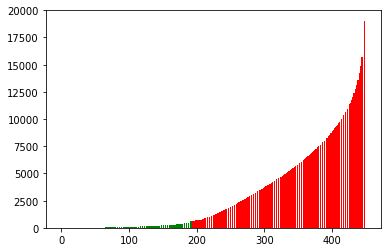

In [309]:
plotConvME(MEConv1Sorted, MEConv2Sorted, MEConv3Sorted)
#plotConvME(MEDiff1Sorted, MEDiff2Sorted, MEDiff3Sorted)

In [310]:
MEDense3Sorted

array([135.62668375, 140.5266115 , 141.89606425, 145.89629375,
       188.398644  , 193.49688163, 205.97463525, 207.61511213,
       413.23679025, 418.10107925])

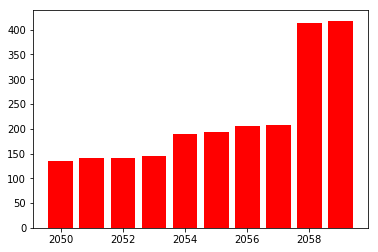

In [314]:
plotDenseME(MEDense1Sorted, MEDense2Sorted, MEDense3Sorted)

In [315]:
def plotDenseME(ME1, ME2, ME3):
    #import numpy as np
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
    x3 = np.arange(len(ME3))
    
    plt.bar(x1, ME1, color = 'b', align = 'center')
    d1=  len(ME1) + 1
    plt.bar(x2+d1, ME2, color = 'g', align = 'center')
    d2 = d1 + len(ME2) + 1
    #location = x2 + len(ME1) 
    plt.bar(x3+d2, ME3, color = 'r', align = 'center')

In [312]:
def plotConvME(ME1, ME2, ME3):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
    x3 = np.arange(len(ME3))
    
    plt.bar(x1, ME1, color = 'b', align = 'center')
    d1=  len(ME1) + 1
    plt.bar(x2+d1, ME2, color = 'g', align = 'center')
    d2 = d1 + len(ME2) + 1
    #location = x2 + len(ME1) 
    plt.bar(x3+d2, ME3, color = 'r', align = 'center')